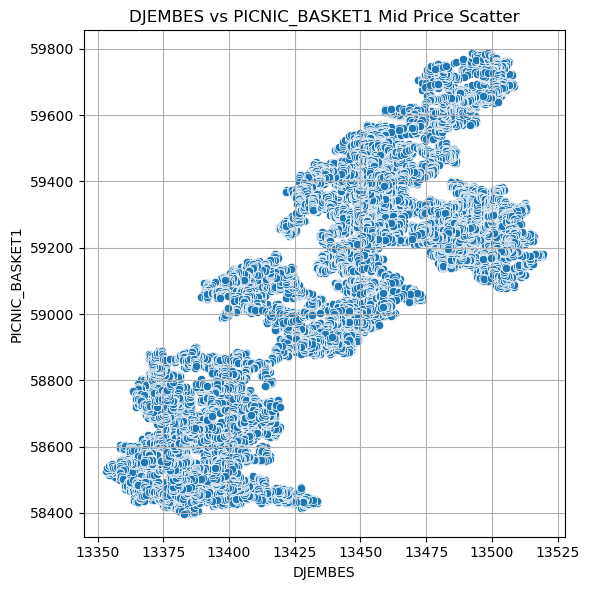

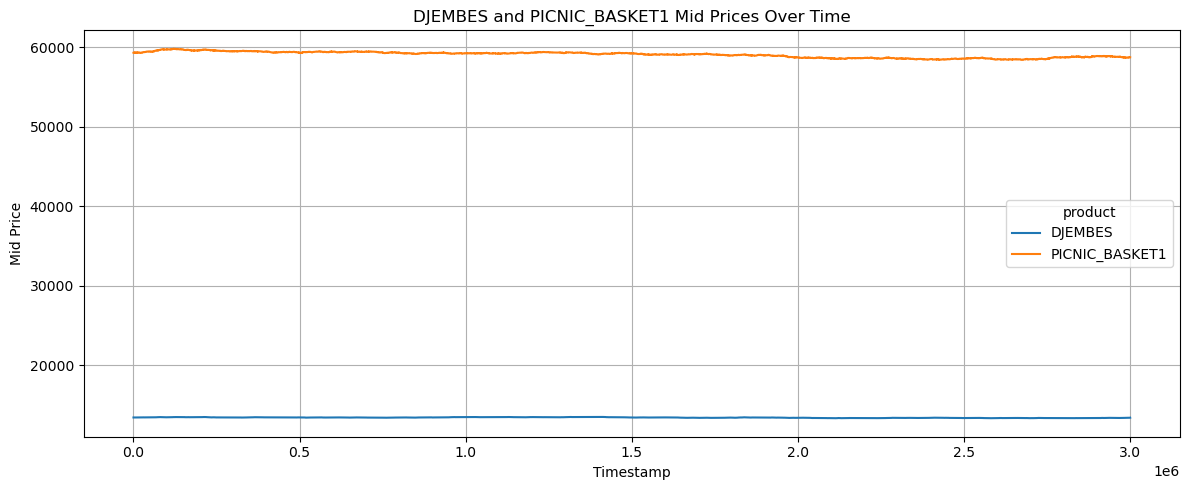

📈 Pearson Correlation:  0.8193
📉 Spearman Correlation: 0.7574


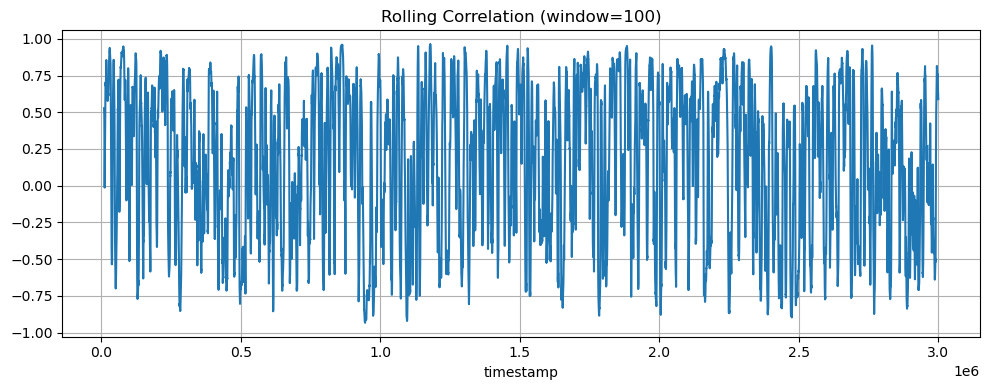

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the full data (assumes same format as earlier)
df = pd.read_csv("data/combined_picnic_data.csv")

# Filter for DJEMBES and BASKET1 only
df_filtered = df[df["product"].isin(["DJEMBES", "PICNIC_BASKET1"])]

# Pivot so both appear in columns
pivot = df_filtered.pivot(index="timestamp", columns="product", values="mid_price").dropna()

# === Scatter Plot ===
plt.figure(figsize=(6, 6))
sns.scatterplot(x="DJEMBES", y="PICNIC_BASKET1", data=pivot)
plt.title("DJEMBES vs PICNIC_BASKET1 Mid Price Scatter")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Time Series Plot ===
pivot.plot(figsize=(12, 5), title="DJEMBES and PICNIC_BASKET1 Mid Prices Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Correlation Coefficients ===
pearson_corr = pivot["DJEMBES"].corr(pivot["PICNIC_BASKET1"])
spearman_corr = pivot["DJEMBES"].corr(pivot["PICNIC_BASKET1"], method="spearman")

print(f"📈 Pearson Correlation:  {pearson_corr:.4f}")
print(f"📉 Spearman Correlation: {spearman_corr:.4f}")

# === Optional: Rolling Correlation (window=100) ===
rolling_corr = pivot["DJEMBES"].rolling(window=100).corr(pivot["PICNIC_BASKET1"])
rolling_corr.plot(title="Rolling Correlation (window=100)", figsize=(10, 4))
plt.grid(True)
plt.tight_layout()
plt.show()


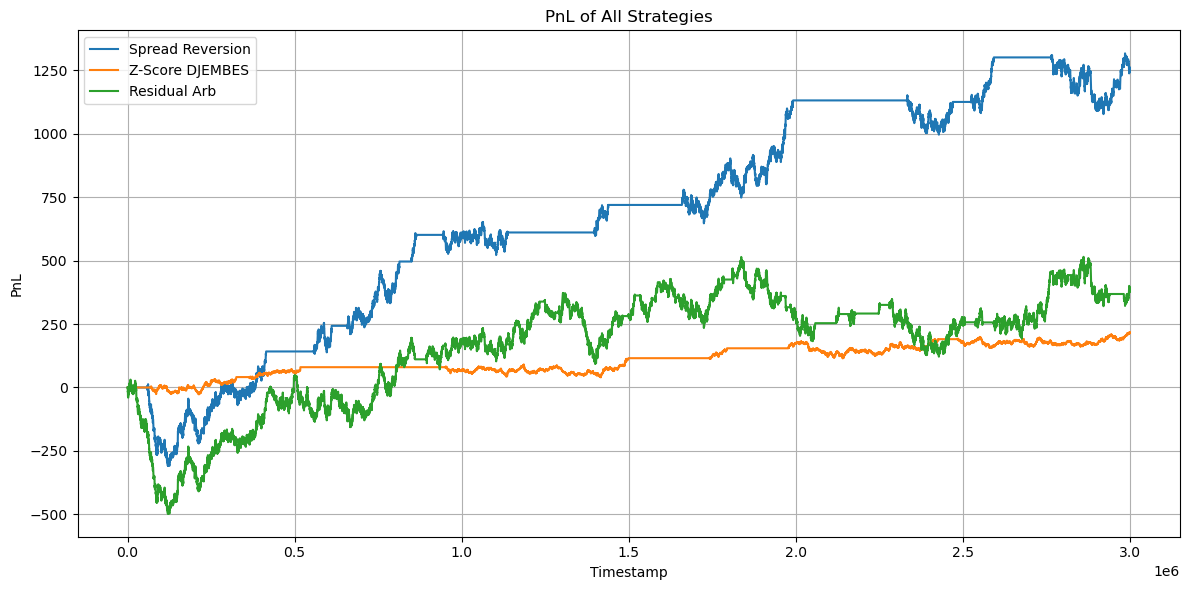

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
from typing import Tuple

# Load data
combined_path = "data/combined_picnic_data.csv"
df = pd.read_csv(combined_path)

# Pivot into wide format
df_pivot = df.pivot(index="timestamp", columns="product", values="mid_price").dropna()

# Calculate theoretical fair value for basket1
df_pivot["FAIR_BASKET1"] = (
    6 * df_pivot["CROISSANTS"] +
    3 * df_pivot["JAMS"] +
    1 * df_pivot["DJEMBES"]
)
df_pivot["SPREAD"] = df_pivot["PICNIC_BASKET1"] - df_pivot["FAIR_BASKET1"]

# Z-score for DJEMBES
djembe_mean = df_pivot["DJEMBES"].mean()
djembe_std = df_pivot["DJEMBES"].std()
df_pivot["Z_DJEMBES"] = (df_pivot["DJEMBES"] - djembe_mean) / djembe_std

# Regression residual
reg = LinearRegression().fit(df_pivot[["DJEMBES"]], df_pivot["PICNIC_BASKET1"])
df_pivot["PREDICTED_BASKET1"] = reg.predict(df_pivot[["DJEMBES"]])
df_pivot["RESIDUAL"] = df_pivot["PICNIC_BASKET1"] - df_pivot["PREDICTED_BASKET1"]

# Strategy Tester
def run_strategy(signal: pd.Series, price: pd.Series, entry_low, entry_high, exit_band, direction="long_short") -> pd.Series:
    position = 0
    cash = 0
    pnl_series = []

    for sig, px in zip(signal, price):
        if position == 0:
            if sig < entry_low:
                position = 1
                cash -= px
            elif sig > entry_high:
                position = -1
                cash += px
        elif position > 0:
            if sig > -exit_band:
                cash += px
                position = 0
        elif position < 0:
            if sig < exit_band:
                cash -= px
                position = 0
        pnl_series.append(cash + position * px)
    return pd.Series(pnl_series, index=signal.index)

# Run strategies
pnl_spread = run_strategy(df_pivot["SPREAD"], df_pivot["PICNIC_BASKET1"], -100, 100, 20)
pnl_z_djembe = run_strategy(df_pivot["Z_DJEMBES"], df_pivot["DJEMBES"], -1.0, 1.0, 0.2)
pnl_resid = run_strategy(df_pivot["RESIDUAL"], df_pivot["PICNIC_BASKET1"], -100, 100, 20)

# Combine results
results = pd.DataFrame({
    "Spread Reversion": pnl_spread,
    "Z-Score DJEMBES": pnl_z_djembe,
    "Residual Arb": pnl_resid,
})


# Plot
plt.figure(figsize=(12, 6))
for col in results.columns:
    plt.plot(results.index, results[col], label=col)
plt.title("PnL of All Strategies")
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/combined_picnic_data.csv")
df = df[df["product"].isin(["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1"])]
df = df.pivot(index="timestamp", columns="product", values="mid_price").dropna()

# Residual = basket1 - (6 * CROISSANTS + 3 * JAMS)
df["residual"] = df["PICNIC_BASKET1"] - (6 * df["CROISSANTS"] + 3 * df["JAMS"])
spread = df["residual"] - df["DJEMBES"]
spread_mean = spread.mean()
spread_std = spread.std()
df["z_score"] = (spread - spread_mean) / spread_std

# === Parameter ranges ===
entry_z_range = np.arange(0.5, 2.6, 0.25)
exit_z_range = np.arange(0.1, 1.6, 0.2)
position_limits = [50]

results = []

# === Grid Search ===
for entry_z in entry_z_range:
    for exit_z in exit_z_range:
        for limit in position_limits:
            position = 0
            cash = 0
            pnl_series = []

            for _, row in df.iterrows():
                z = row["z_score"]
                price = row["DJEMBES"]

                if position == 0:
                    if z > entry_z:
                        position = -limit
                        cash += price * limit
                    elif z < -entry_z:
                        position = limit
                        cash -= price * limit
                elif position > 0 and z > -exit_z:
                    cash += price * position
                    position = 0
                elif position < 0 and z < exit_z:
                    cash -= price * abs(position)
                    position = 0

                # Mark-to-market
                pnl = cash + position * price
                pnl_series.append(pnl)

            final_pnl = pnl_series[-1]
            results.append((entry_z, exit_z, limit, final_pnl))

# Save and sort results
results_df = pd.DataFrame(results, columns=["entry_z", "exit_z", "position_limit", "pnl"])
results_df = results_df.sort_values("pnl", ascending=False).reset_index(drop=True)
results_df.to_csv("residual_arb_djembe_optimization.csv", index=False)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load optimization results
results_df = pd.read_csv("residual_arb_djembe_optimization.csv")

# Show top 10 results
top = results_df.sort_values("pnl", ascending=False).head(10)
print(top)


   entry_z  exit_z  position_limit     pnl
0     0.75     1.3              50  7575.0
1     0.50     1.1              50  6000.0
2     0.50     1.3              50  5575.0
3     0.75     1.1              50  5425.0
4     1.25     1.3              50  5225.0
5     1.25     1.1              50  5175.0
6     0.50     0.1              50  4975.0
7     1.00     1.3              50  4875.0
8     1.50     1.5              50  4850.0
9     0.75     0.1              50  4500.0


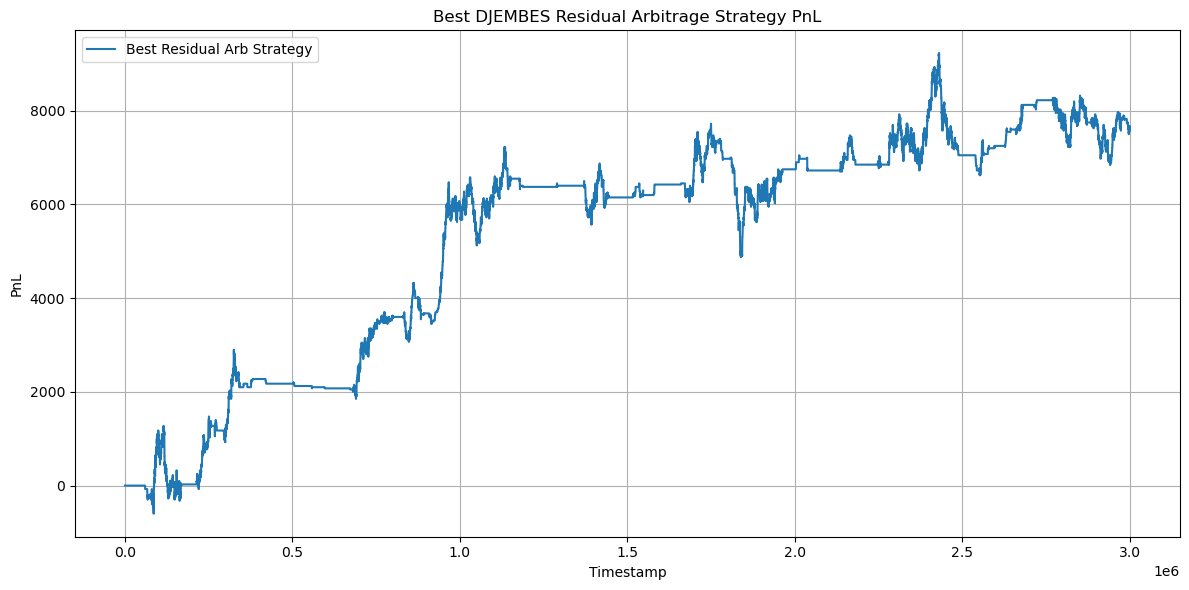

In [13]:
import numpy as np

# Load full price data again
df = pd.read_csv("data/combined_picnic_data.csv")
df = df[df["product"].isin(["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1"])]
df = df.pivot(index="timestamp", columns="product", values="mid_price").dropna()

# Recompute spread
df["residual"] = df["PICNIC_BASKET1"] - (6 * df["CROISSANTS"] + 3 * df["JAMS"])
spread = df["residual"] - df["DJEMBES"]
spread_mean = spread.mean()
spread_std = spread.std()
df["z_score"] = (spread - spread_mean) / spread_std

# Get best parameters
best_row = top.iloc[0]
entry_z = best_row["entry_z"]
exit_z = best_row["exit_z"]
limit = int(best_row["position_limit"])

# Simulate strategy
position = 0
cash = 0
pnl_series = []

for _, row in df.iterrows():
    z = row["z_score"]
    price = row["DJEMBES"]

    if position == 0:
        if z > entry_z:
            position = -limit
            cash += price * limit
        elif z < -entry_z:
            position = limit
            cash -= price * limit
    elif position > 0 and z > -exit_z:
        cash += price * position
        position = 0
    elif position < 0 and z < exit_z:
        cash -= price * abs(position)
        position = 0

    pnl = cash + position * price
    pnl_series.append(pnl)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(pnl_series)], pnl_series, label="Best Residual Arb Strategy")
plt.title("Best DJEMBES Residual Arbitrage Strategy PnL")
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
spread.mean(), spread.std()

(48.762433333333334, 85.1194508094893)

In [15]:
import pandas as pd
import numpy as np

# Load combined data with all necessary products
df = pd.read_csv("data/combined_picnic_data.csv")
df = df[df["product"].isin(["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1"])]
df = df.pivot(index="timestamp", columns="product", values="mid_price").dropna()

# Compute residual: PB1 - (6*CR + 3*JM + DJ)
df["residual"] = df["PICNIC_BASKET1"] - (6 * df["CROISSANTS"] + 3 * df["JAMS"] + df["DJEMBES"])
residual_mean = df["residual"].mean()
residual_std = df["residual"].std()
df["z_score"] = (df["residual"] - residual_mean) / residual_std

# Parameters to search
threshold_range = np.linspace(0.3, 1.5, 13)
exit_range = np.linspace(0.05, 0.5, 10)
limit = 60  # Fixed position cap

results = []

# Grid search loop
for entry_z in threshold_range:
    for exit_z in exit_range:
        position = 0
        cash = 0
        pnl_list = []

        for _, row in df.iterrows():
            z = row["z_score"]
            price = row["DJEMBES"]

            # === ENTRY ===
            if position == 0:
                if z > entry_z:
                    position = -limit
                    cash += limit * price
                elif z < -entry_z:
                    position = limit
                    cash -= limit * price

            # === EXIT ===
            elif abs(z) < exit_z:
                cash += position * price
                position = 0

            # Mark-to-market
            pnl = cash + position * price
            pnl_list.append(pnl)

        final_pnl = pnl_list[-1]
        results.append((entry_z, exit_z, final_pnl))

# Save and sort
results_df = pd.DataFrame(results, columns=["entry_z", "exit_z", "pnl"])
results_df = results_df.sort_values("pnl", ascending=False).reset_index(drop=True)
results_df.to_csv("residual_djembe_param_grid.csv", index=False)


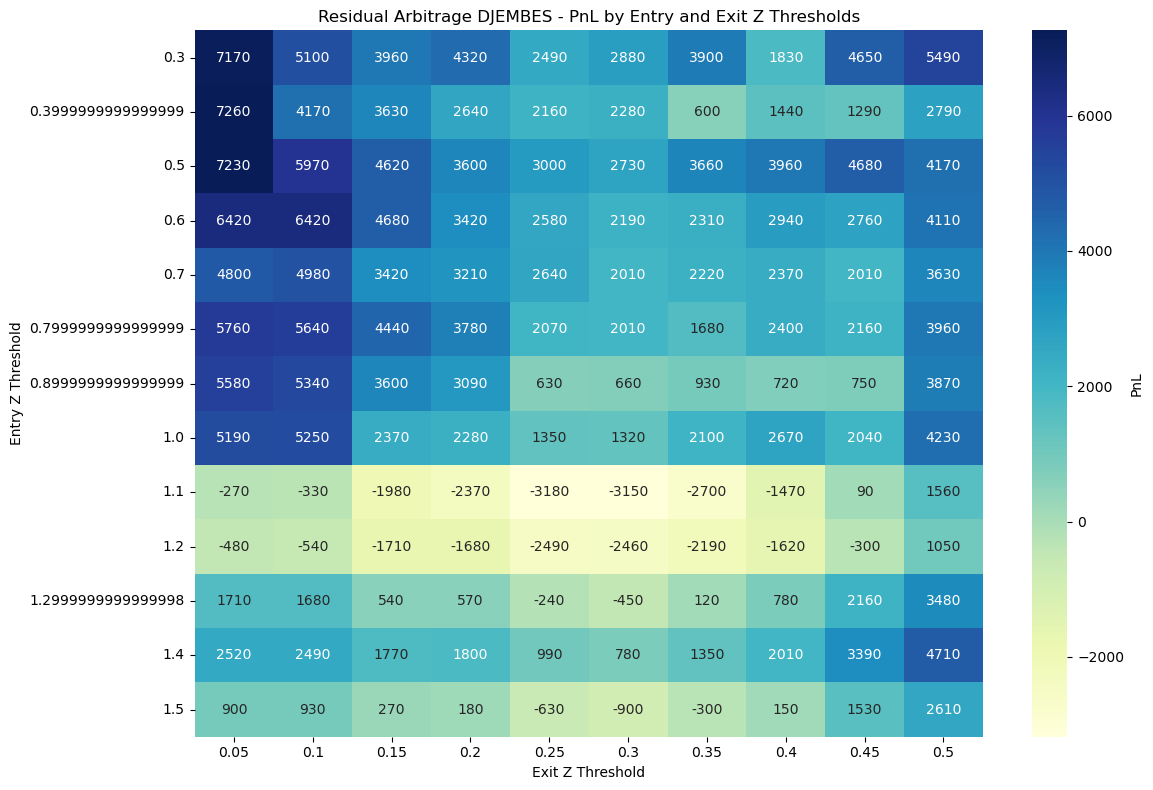

,entry_z,exit_z,pnl
0,0.4,0.05,7260.0
1,0.5,0.05,7230.0
2,0.3,0.05,7170.0
3,0.6,0.05,6420.0
4,0.6,0.10,6420.0
5,0.5,0.10,5970.0
6,0.8,0.05,5760.0
7,0.8,0.10,5640.0
8,0.9,0.05,5580.0
9,0.3,0.50,5490.0


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the parameter sweep result
df = pd.read_csv("residual_djembe_param_grid.csv")

# Get top 10 best parameters
top_10 = df.sort_values("pnl", ascending=False).head(10)

# Create pivot table for heatmap
heatmap_data = df.pivot(index="entry_z", columns="exit_z", values="pnl")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'PnL'})
plt.title("Residual Arbitrage DJEMBES - PnL by Entry and Exit Z Thresholds")
plt.xlabel("Exit Z Threshold")
plt.ylabel("Entry Z Threshold")
plt.tight_layout()
plt.show()

# Display best parameters
top_10


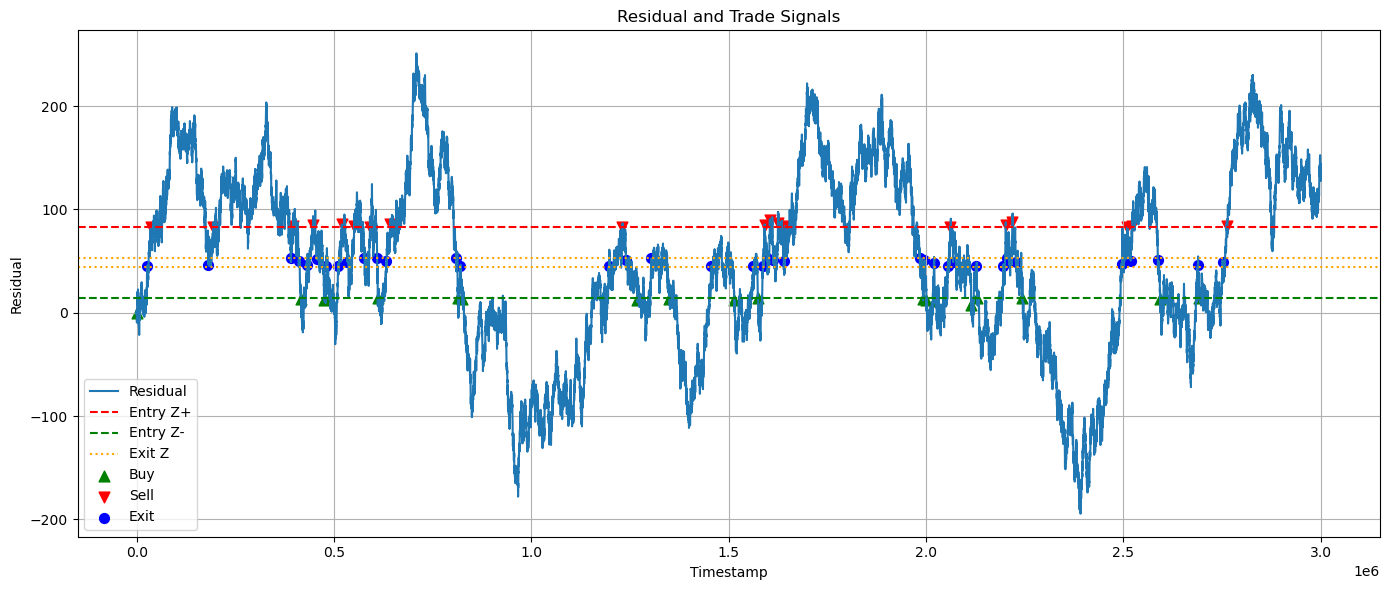

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_residual_and_trades(df, entry_z=0.4, exit_z=0.05, limit=50):
    # Compute residual and z-score
    df = df.copy()
    df["residual"] = df["PICNIC_BASKET1"] - (6 * df["CROISSANTS"] + 3 * df["JAMS"] + df["DJEMBES"])
    mean = df["residual"].mean()
    std = df["residual"].std()
    df["z_score"] = (df["residual"] - mean) / std

    # Track trade events
    position = 0
    buys = []
    sells = []
    exits = []

    for i, row in df.iterrows():
        z = row["z_score"]
        if position == 0:
            if z < -entry_z:
                position = limit
                buys.append((i, row["residual"]))
            elif z > entry_z:
                position = -limit
                sells.append((i, row["residual"]))
        elif abs(z) < exit_z:
            exits.append((i, row["residual"]))
            position = 0

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df["residual"], label="Residual", linewidth=1.5)
    plt.axhline(mean + entry_z * std, color="red", linestyle="--", label="Entry Z+")
    plt.axhline(mean - entry_z * std, color="green", linestyle="--", label="Entry Z-")
    plt.axhline(mean + exit_z * std, color="orange", linestyle=":", label="Exit Z")
    plt.axhline(mean - exit_z * std, color="orange", linestyle=":")

    # Scatter trade signals
    if buys:
        buy_idx, buy_val = zip(*buys)
        plt.scatter(buy_idx, buy_val, marker="^", color="green", label="Buy", s=60)
    if sells:
        sell_idx, sell_val = zip(*sells)
        plt.scatter(sell_idx, sell_val, marker="v", color="red", label="Sell", s=60)
    if exits:
        exit_idx, exit_val = zip(*exits)
        plt.scatter(exit_idx, exit_val, marker="o", color="blue", label="Exit", s=50)

    plt.title("Residual and Trade Signals")
    plt.xlabel("Timestamp")
    plt.ylabel("Residual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

pivot_df = pd.read_csv("data/combined_picnic_data.csv")
pivot_df = pivot_df.pivot(index="timestamp", columns="product", values="mid_price").dropna()
plot_residual_and_trades(pivot_df, entry_z=0.4, exit_z=0.05, limit=60)

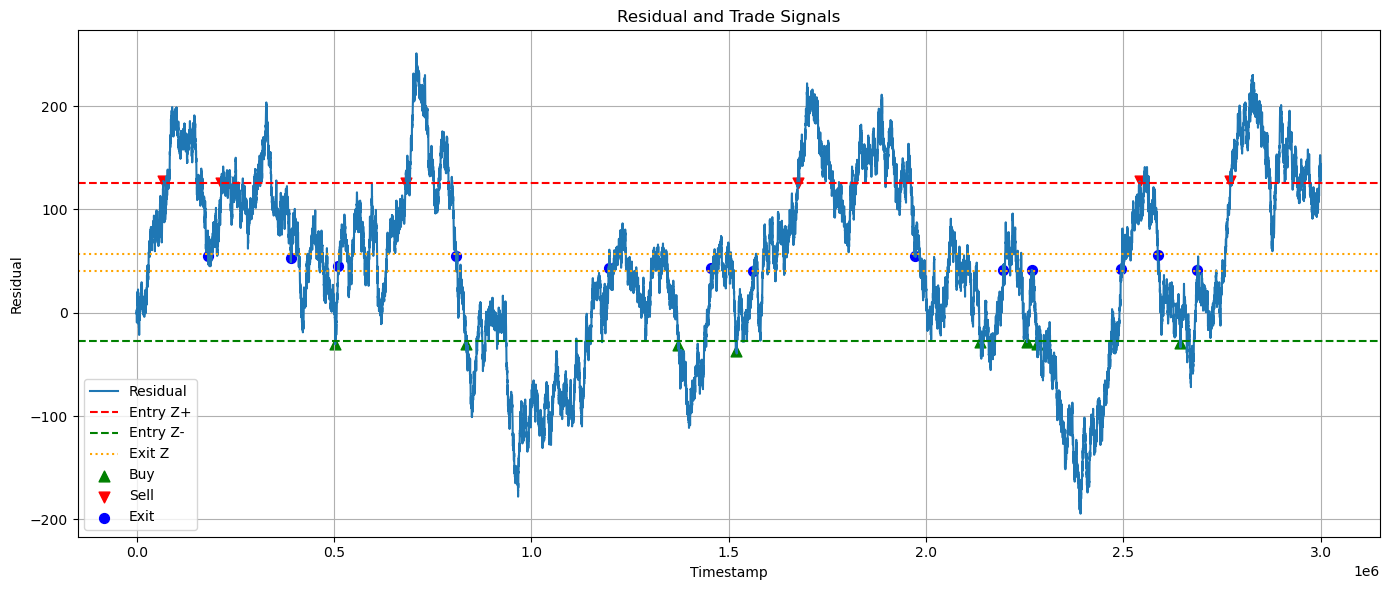

NameError: name 's' is not defined

In [19]:
plot_residual_and_trades(pivot_df, entry_z=0.9, exit_z=0.1, limit=60)
s

In [ ]:
import numpy as np
import pandas as pd

# Load and prepare mid prices
df = pd.read_csv("data/combined_picnic_data.csv")  # Or appropriate CSV
pivot_df = df.pivot(index="timestamp", columns="product", values="mid_price").dropna()

# Calculate the ratio
pivot_df["ratio"] = pivot_df["DJEMBES"] / pivot_df["PICNIC_BASKET1"]
mean = pivot_df["ratio"].mean()
std = pivot_df["ratio"].std()
pivot_df["z"] = (pivot_df["ratio"] - mean) / std

# Define parameter grid
entry_thresholds = [0.48]
exit_thresholds = np.linspace(.1, .3, 7)
results = []

# Grid search
for entry in entry_thresholds:
    for exit in exit_thresholds:
        if exit >= entry:
            continue
        cash = 0
        position = 0
        pnl_list = []

        for _, row in pivot_df.iterrows():
            price = row["DJEMBES"]
            z = row["z"]

            if position == 0:
                if z > entry:
                    position = -1
                    cash += price
                elif z < -entry:
                    position = 1
                    cash -= price
            elif position == 1 and z > -exit:
                cash += price
                position = 0
            elif position == -1 and z < exit:
                cash -= price
                position = 0

            mark = cash + (price * position)
            pnl_list.append(mark)

        results.append((entry, exit, pnl_list[-1]))

# Best config
results_df = pd.DataFrame(results, columns=["entry_z", "exit_z", "pnl"])
results_df = results_df.sort_values("pnl", ascending=False)
print(results_df.head())


    entry_z  exit_z    pnl
2  0.481818       0  167.5
3  0.672727       0  147.0
1  0.290909       0  143.5
4  0.863636       0  103.5
0  0.100000       0   61.5


In [21]:
import pandas as pd

# Load and prepare the combined CSV with all prices (make sure it includes both DJEMBES and PICNIC_BASKET1)
df = pd.read_csv("data/combined_picnic_data.csv")  # or concatenate your price files
df = df[df["product"].isin(["DJEMBES", "PICNIC_BASKET1"])]

# Pivot to get mid prices by product
pivot_df = df.pivot(index="timestamp", columns="product", values="mid_price")

# Drop rows where either product has missing data
pivot_df = pivot_df.dropna(subset=["DJEMBES", "PICNIC_BASKET1"])

# Compute the ratio
pivot_df["ratio"] = pivot_df["DJEMBES"] / pivot_df["PICNIC_BASKET1"]

# Calculate mean and standard deviation
mean_ratio = pivot_df["ratio"].mean()
std_ratio = pivot_df["ratio"].std()

print(f"Mean Ratio: {mean_ratio:.6f}")
print(f"Std Dev of Ratio: {std_ratio:.6f}")


Mean Ratio: 0.227537
Std Dev of Ratio: 0.000907
